# MultiSceneDataset 和 RGBPointCloudGenerator 使用演示

本 notebook 展示 MultiSceneDataset 和 RGBPointCloudGenerator 的基本使用方式和核心功能。

## 功能概述

### MultiSceneDataset
1. 多场景数据集管理（训练/评估场景划分）
2. 基于关键帧机制的场景分割
3. 段（Segment）级别的数据组织
4. Source 和 Target 图像对生成
5. 调度器（Scheduler）管理训练流程

### RGBPointCloudGenerator
1. 从 MultiSceneDataset 的段中生成 RGB 点云
2. 支持多种稀疏度级别（Drop90, Drop80, Drop50, Drop25, full）
3. 支持天空过滤和深度一致性检查
4. 支持边界框裁剪和点云滤波

## 使用说明

1. 按顺序执行所有单元格
2. 在"数据配置"单元格中修改配置文件路径
3. 每个部分可以独立运行和调试
4. 注意内存使用，特别是点云生成部分


## 第一部分：MultiSceneDataset 基础

### 1. 环境配置

安装和导入所有必要的依赖包。


In [1]:
# 安装依赖（如果需要）
# !pip install numpy matplotlib open3d omegaconf torch

import os
import sys
import numpy as np
import torch
from omegaconf import OmegaConf
from typing import List, Dict, Optional
import matplotlib.pyplot as plt
import open3d as o3d

# 添加项目路径以导入模块
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

# 导入项目模块
from datasets.multi_scene_dataset import MultiSceneDataset
from datasets.pointcloud_generators.rgb_pointcloud_generator import MonocularRGBPointCloudGenerator

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 设置随机种子（可选，用于可重复性）
torch.manual_seed(42)
np.random.seed(42)

print("Environment setup completed!")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using device: cuda
Environment setup completed!


### 2. 数据配置准备

读取配置文件，准备数据配置。


In [2]:
# 读取配置文件
config_path = os.path.join(project_root, "configs/evolsplat/multi_scene.yaml")
cfg = OmegaConf.load(config_path)

# 提取数据配置
data_cfg = cfg.data

# 提取 MultiSceneDataset 配置
multi_scene_cfg = cfg.multi_scene

# 显示配置信息
print("Data configuration:")
print(f"  Data root: {data_cfg.data_root}")
print(f"  Dataset type: {data_cfg.dataset}")
print(f"  Train scene IDs: {data_cfg.train_scene_ids}")
print(f"  Eval scene IDs: {data_cfg.eval_scene_ids}")

print("\nMultiSceneDataset configuration:")
print(f"  Num source keyframes: {multi_scene_cfg.num_source_keyframes}")
print(f"  Num target keyframes: {multi_scene_cfg.num_target_keyframes}")
print(f"  Segment overlap ratio: {multi_scene_cfg.segment_overlap_ratio}")
print(f"  Min keyframes per scene: {multi_scene_cfg.min_keyframes_per_scene}")
print(f"  Min keyframes per segment: {multi_scene_cfg.min_keyframes_per_segment}")
print(f"  Fixed segment AABB: {multi_scene_cfg.fixed_segment_aabb}")

# 显示 pointcloud 配置（如果存在）
if hasattr(data_cfg, 'pointcloud'):
    print("\nPoint cloud configuration:")
    print(f"  Sparsity: {data_cfg.pointcloud.get('sparsity', 'N/A')}")
    print(f"  Filter sky: {data_cfg.pointcloud.get('filter_sky', 'N/A')}")
    print(f"  Depth consistency: {data_cfg.pointcloud.get('depth_consistency', 'N/A')}")
    print(f"  Use bounding box: {data_cfg.pointcloud.get('use_bbx', 'N/A')}")
    print(f"  Downscale: {data_cfg.pointcloud.get('downscale', 'N/A')}")
    print(f"  Crop AABB: {data_cfg.pointcloud.get('crop_aabb', 'N/A')}")
    print(f"  Input AABB: {data_cfg.pointcloud.get('input_aabb', 'N/A')}")

# 准备 fixed_segment_aabb（如果配置了）
fixed_segment_aabb = None
if multi_scene_cfg.fixed_segment_aabb is not None:
    fixed_segment_aabb = torch.tensor(multi_scene_cfg.fixed_segment_aabb, dtype=torch.float32)
    print(f"\nUsing fixed segment AABB: {fixed_segment_aabb}")


Data configuration:
  Data root: /mnt/f/DataSet/nuScenes/processed/trainval
  Dataset type: nuscenes
  Train scene IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  Eval scene IDs: [10, 11, 12, 13, 14]

MultiSceneDataset configuration:
  Num source keyframes: 3
  Num target keyframes: 6
  Segment overlap ratio: 0.2
  Min keyframes per scene: 10
  Min keyframes per segment: 6
  Fixed segment AABB: [[-20, -20, -5], [70, 20, 5]]

Point cloud configuration:
  Sparsity: full
  Filter sky: True
  Depth consistency: True
  Use bounding box: True
  Downscale: 2
  Crop AABB: [[-20, -20, -20], [20, 4.8, 70]]
  Input AABB: [[-20, -20, -20], [20, 4.8, 70]]

Using fixed segment AABB: tensor([[-20., -20.,  -5.],
        [ 70.,  20.,   5.]])


### 3. 创建 MultiSceneDataset 实例

创建 MultiSceneDataset 实例，配置参数说明：
- `train_scene_ids`: 训练场景ID列表
- `eval_scene_ids`: 评估场景ID列表
- `num_source_keyframes`: Source 使用的关键帧数量（默认3）
- `num_target_keyframes`: Target 使用的关键帧数量（默认6，包含source）
- `segment_overlap_ratio`: 段与段之间的重叠比例（默认0.2）
- `keyframe_split_config`: 关键帧分割配置
- `min_keyframes_per_scene`: 场景的最小关键帧数量，不满足则跳过
- `min_keyframes_per_segment`: 段的最小关键帧数量，不满足则跳过
- `fixed_segment_aabb`: 可选的全局固定段AABB


In [3]:
# 创建 MultiSceneDataset 实例
dataset = MultiSceneDataset(
    data_cfg=data_cfg,
    train_scene_ids=data_cfg.train_scene_ids,
    eval_scene_ids=data_cfg.eval_scene_ids,
    num_source_keyframes=multi_scene_cfg.num_source_keyframes,
    num_target_keyframes=multi_scene_cfg.num_target_keyframes,
    segment_overlap_ratio=multi_scene_cfg.segment_overlap_ratio,
    keyframe_split_config=dict(multi_scene_cfg.keyframe_split_config),
    min_keyframes_per_scene=multi_scene_cfg.min_keyframes_per_scene,
    min_keyframes_per_segment=multi_scene_cfg.min_keyframes_per_segment,
    device=device,
    preload_scene_count=1,  # 预加载3个场景
    fixed_segment_aabb=fixed_segment_aabb,
)

print("MultiSceneDataset created successfully!")


MultiSceneDataset created successfully!


### 4. 初始化数据集

初始化训练队列和预加载初始场景。


In [4]:
# 初始化数据集（可选，会在第一次使用时自动初始化）
# 但显式调用可以提前检测错误
dataset.initialize()

# 获取当前场景ID
current_scene_id = dataset.get_current_scene_id()
print(f"Current training scene ID: {current_scene_id}")

if current_scene_id is None:
    print("Warning: No valid training scenes found after validation")
else:
    print(f"Dataset initialized successfully with scene {current_scene_id}")


Loading lidar: 100%|██████████| 196/196 [00:03<00:00, 51.57it/s]
Projecting lidar pts on images for camera CAM_FRONT: 100%|██████████| 196/196 [00:02<00:00, 95.93it/s] 
Projecting lidar pts on images for camera CAM_FRONT_LEFT: 100%|██████████| 196/196 [00:02<00:00, 97.26it/s]
Projecting lidar pts on images for camera CAM_FRONT_RIGHT: 100%|██████████| 196/196 [00:02<00:00, 95.78it/s]
Loading lidar: 100%|██████████| 196/196 [00:03<00:00, 53.15it/s]
Projecting lidar pts on images for camera CAM_FRONT: 100%|██████████| 196/196 [00:02<00:00, 83.84it/s]
Projecting lidar pts on images for camera CAM_FRONT_LEFT: 100%|██████████| 196/196 [00:02<00:00, 82.01it/s]
Projecting lidar pts on images for camera CAM_FRONT_RIGHT: 100%|██████████| 196/196 [00:02<00:00, 81.71it/s]
Loading lidar: 100%|██████████| 196/196 [00:02<00:00, 87.86it/s]
Projecting lidar pts on images for camera CAM_FRONT: 100%|██████████| 196/196 [00:02<00:00, 83.97it/s]
Projecting lidar pts on images for camera CAM_FRONT_LEFT: 100

Current training scene ID: 8
Dataset initialized successfully with scene 8


### 5. 获取场景信息

使用 `get_scene()` 获取场景信息，包括段、关键帧、帧数、相机数等。


In [5]:
# 获取场景信息（使用第一个训练场景作为示例）
scene_id = data_cfg.train_scene_ids[0] if len(data_cfg.train_scene_ids) > 0 else None

if scene_id is not None:
    scene_info = dataset.get_scene(scene_id)
    
    if scene_info is not None:
        print(f"Scene {scene_id} information:")
        print(f"  Number of frames: {scene_info['num_frames']}")
        print(f"  Number of cameras: {scene_info['num_cams']}")
        print(f"  Number of segments: {len(scene_info['segments'])}")
        print(f"  Number of keyframe segments: {len(scene_info['keyframe_segments'])}")
        
        # 显示每个段的信息
        print("\nSegment information:")
        for i, segment in enumerate(scene_info['segments']):
            print(f"  Segment {i}:")
            print(f"    Keyframe indices: {segment['keyframe_indices']}")
            print(f"    Number of frames: {len(segment['frame_indices'])}")
            print(f"    AABB shape: {segment['aabb'].shape}")
            print(f"    AABB min: {segment['aabb'][0]}")
            print(f"    AABB max: {segment['aabb'][1]}")
        
        # 显示关键帧信息
        print("\nKeyframe segments (first 5):")
        for i, kf_seg in enumerate(scene_info['keyframe_segments'][:5]):
            print(f"  Keyframe {i}: {len(kf_seg)} frames")
    else:
        print(f"Scene {scene_id} not found or not loaded")
else:
    print("No training scenes available")


Loading lidar: 100%|██████████| 196/196 [00:03<00:00, 55.29it/s]
Projecting lidar pts on images for camera CAM_FRONT: 100%|██████████| 196/196 [00:02<00:00, 75.23it/s]
Projecting lidar pts on images for camera CAM_FRONT_LEFT: 100%|██████████| 196/196 [00:02<00:00, 76.28it/s]
Projecting lidar pts on images for camera CAM_FRONT_RIGHT: 100%|██████████| 196/196 [00:02<00:00, 75.74it/s]


Scene 0 information:
  Number of frames: 196
  Number of cameras: 3
  Number of segments: 2
  Number of keyframe segments: 37

Segment information:
  Segment 0:
    Keyframe indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
    Number of frames: 105
    AABB shape: torch.Size([2, 3])
    AABB min: tensor([-20., -20.,  -5.], device='cuda:0')
    AABB max: tensor([70., 20.,  5.], device='cuda:0')
  Segment 1:
    Keyframe indices: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
    Number of frames: 92
    AABB shape: torch.Size([2, 3])
    AABB min: tensor([-20., -20.,  -5.], device='cuda:0')
    AABB max: tensor([70., 20.,  5.], device='cuda:0')

Keyframe segments (first 5):
  Keyframe 0: 6 frames
  Keyframe 1: 6 frames
  Keyframe 2: 5 frames
  Keyframe 3: 6 frames
  Keyframe 4: 5 frames


### 6. 获取批次数据

使用 `get_segment_batch()` 获取指定场景和段的训练批次。
批次包含 source 和 target 的图像、外参、内参、深度等信息。


Batch information:
  Scene ID: 0
  Segment ID: 0

Source data:
  Image shape: torch.Size([9, 300, 533, 3])
  Extrinsics shape: torch.Size([9, 4, 4])
  Intrinsics shape: torch.Size([9, 4, 4])
  Depth shape: torch.Size([9, 300, 533])
  Frame indices shape: torch.Size([9])
  Cam indices shape: torch.Size([9])
  Keyframe indices: [3, 9, 16]

Target data:
  Image shape: torch.Size([18, 300, 533, 3])
  Extrinsics shape: torch.Size([18, 4, 4])
  Intrinsics shape: torch.Size([18, 4, 4])
  Depth shape: torch.Size([18, 300, 533])
  Frame indices shape: torch.Size([18])
  Cam indices shape: torch.Size([18])
  Keyframe indices: [3, 9, 16, 18, 15, 10]

Keyframe info:
  Segment keyframes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
  Source keyframes: [3, 9, 16]
  Target keyframes: [3, 9, 16, 18, 15, 10]

Visualizing first source image...


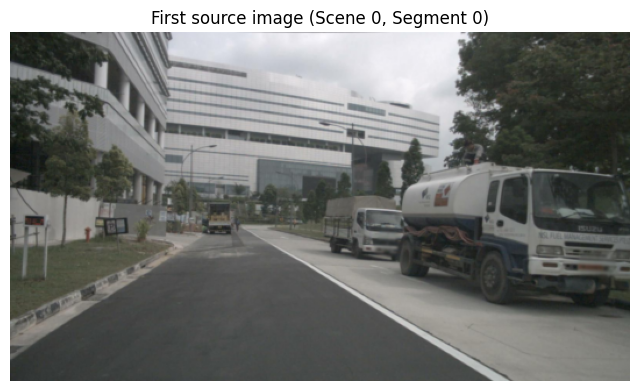

In [6]:
# 获取指定场景和段的批次
if scene_id is not None and scene_info is not None and len(scene_info['segments']) > 0:
    segment_id = 0  # 使用第一个段
    batch = dataset.get_segment_batch(scene_id, segment_id)
    
    print("Batch information:")
    print(f"  Scene ID: {batch['scene_id'].item()}")
    print(f"  Segment ID: {batch['segment_id']}")
    
    # Source 信息
    print("\nSource data:")
    print(f"  Image shape: {batch['source']['image'].shape}")
    print(f"  Extrinsics shape: {batch['source']['extrinsics'].shape}")
    print(f"  Intrinsics shape: {batch['source']['intrinsics'].shape}")
    print(f"  Depth shape: {batch['source']['depth'].shape}")
    print(f"  Frame indices shape: {batch['source']['frame_indices'].shape}")
    print(f"  Cam indices shape: {batch['source']['cam_indices'].shape}")
    print(f"  Keyframe indices: {batch['source']['keyframe_indices'].tolist()}")
    
    # Target 信息
    print("\nTarget data:")
    print(f"  Image shape: {batch['target']['image'].shape}")
    print(f"  Extrinsics shape: {batch['target']['extrinsics'].shape}")
    print(f"  Intrinsics shape: {batch['target']['intrinsics'].shape}")
    print(f"  Depth shape: {batch['target']['depth'].shape}")
    print(f"  Frame indices shape: {batch['target']['frame_indices'].shape}")
    print(f"  Cam indices shape: {batch['target']['cam_indices'].shape}")
    print(f"  Keyframe indices: {batch['target']['keyframe_indices'].tolist()}")
    
    # 关键帧信息
    print("\nKeyframe info:")
    print(f"  Segment keyframes: {batch['keyframe_info']['segment_keyframes']}")
    print(f"  Source keyframes: {batch['keyframe_info']['source_keyframes']}")
    print(f"  Target keyframes: {batch['keyframe_info']['target_keyframes']}")
    
    # 可视化部分图像（可选）
    print("\nVisualizing first source image...")
    first_source_image = batch['source']['image'][0].cpu().numpy()
    # 确保图像值在 [0, 1] 范围内
    if first_source_image.max() > 1.0:
        first_source_image = first_source_image / 255.0
    
    plt.figure(figsize=(8, 6))
    plt.imshow(first_source_image)
    plt.title(f"First source image (Scene {scene_id}, Segment {segment_id})")
    plt.axis('off')
    plt.show()
else:
    print("Cannot get batch: scene or segment not available")


### 7. 随机采样批次

使用 `sample_random_batch()` 随机采样一个训练批次。


In [7]:
# 随机采样一个批次
random_batch = dataset.sample_random_batch()

print("Random batch information:")
print(f"  Scene ID: {random_batch['scene_id'].item()}")
print(f"  Segment ID: {random_batch['segment_id']}")
print(f"  Source images: {random_batch['source']['image'].shape[0]}")
print(f"  Target images: {random_batch['target']['image'].shape[0]}")

# 可以多次采样查看随机性
print("\nSampling 5 random batches to show randomness:")
for i in range(5):
    batch = dataset.sample_random_batch()
    print(f"  Batch {i+1}: Scene {batch['scene_id'].item()}, Segment {batch['segment_id']}")


Random batch information:
  Scene ID: 8
  Segment ID: 4
  Source images: 9
  Target images: 18

Sampling 5 random batches to show randomness:
  Batch 1: Scene 8, Segment 6
  Batch 2: Scene 8, Segment 6
  Batch 3: Scene 8, Segment 9
  Batch 4: Scene 8, Segment 1
  Batch 5: Scene 8, Segment 8


### 8. 使用调度器

使用 `create_scheduler()` 创建调度器，管理场景和段的遍历顺序。
调度器自动管理段内batch计数、段切换、场景切换和场景预加载。


In [7]:
# 创建调度器
scheduler = dataset.create_scheduler(
    batches_per_segment=20,  # 每个段遍历20个batch
    segment_order="random",  # 段遍历顺序：random 或 sequential
    scene_order="random",  # 场景遍历顺序：random 或 sequential
    shuffle_segments=True,  # 是否在每个场景内打乱段顺序
    preload_next_scene=True,  # 是否在最后一个段开始训练时预加载下一个场景
)

print("Scheduler created successfully!")

# 获取当前状态信息
info = scheduler.get_current_info()
print(f"\nCurrent scheduler state:")
print(f"  Scene ID: {info['scene_id']}")
print(f"  Segment ID (in scene): {info['segment_id_in_scene']}")
print(f"  Batch count: {info['batch_count']}/{info['batches_per_segment']}")

# 演示获取几个批次
print("\nGetting next batches:")
for i in range(3):
    try:
        batch = scheduler.next_batch()
        current_info = scheduler.get_current_info()
        print(f"  Batch {i+1}: Scene {batch['scene_id'].item()}, "
              f"Segment {current_info['segment_id_in_scene']}, "
              f"Batch count {current_info['batch_count']}/{current_info['batches_per_segment']}")
    except StopIteration:
        print("  All scenes have been processed")
        break

# 注意：在实际使用中，应该在 finally 块中调用 shutdown() 清理资源
# scheduler.shutdown()


Scheduler created successfully!

Current scheduler state:
  Scene ID: 4
  Segment ID (in scene): 4
  Batch count: 0/20

Getting next batches:
  Batch 1: Scene 4, Segment 4, Batch count 1/20
  Batch 2: Scene 4, Segment 4, Batch count 2/20
  Batch 3: Scene 4, Segment 4, Batch count 3/20


## 第二部分：RGBPointCloudGenerator 基础

### 9. RGBPointCloudGenerator 介绍

RGBPointCloudGenerator 用于从 MultiSceneDataset 的段中生成 RGB 点云。
它支持多种稀疏度级别、天空过滤、深度一致性检查等功能。


### 10. 创建点云生成器

创建 `MonocularRGBPointCloudGenerator` 实例，配置参数说明：
- `chosen_cam_ids`: 选择使用的相机ID列表（例如 [0] 表示只使用前置摄像头）
- `sparsity`: 稀疏度级别（'Drop90', 'Drop80', 'Drop50', 'Drop25', 'full'）
- `filter_sky`: 是否过滤天空区域
- `depth_consistency`: 是否进行深度一致性检查
- `use_bbx`: 是否使用边界框裁剪
- `downscale`: 点云生成时的下采样倍数
- `crop_aabb`: 裁剪边界框（必需，shape [2, 3]）
- `input_aabb`: 输入边界框（必需，shape [2, 3]）


In [11]:
# 创建点云生成器
pointcloud_generator = MonocularRGBPointCloudGenerator(
    chosen_cam_ids=[0, 1, 2],  # 只使用前置摄像头（索引0）
    sparsity='Drop50',  # 稀疏度级别：Drop90, Drop80, Drop50, Drop25, full
    filter_sky=True,  # 是否过滤天空区域
    depth_consistency=True,  # 是否进行深度一致性检查
    use_bbx=True,  # 是否使用边界框裁剪
    downscale=2,  # 下采样倍数
    crop_aabb=np.array([[-10, -20, -5], [70, 20, 5]]),  # 裁剪边界框
    input_aabb=np.array([[-20, -20, -20], [20, 4.8, 70]]),  # 输入边界框
    device=device,
)

print("Point cloud generator created successfully!")
print(f"  Chosen cameras: {pointcloud_generator.chosen_cam_ids}")
print(f"  Sparsity: {pointcloud_generator.sparsity}")
print(f"  Filter sky: {pointcloud_generator.filter_sky}")
print(f"  Depth consistency: {pointcloud_generator.depth_consistency}")
print(f"  Use bounding box: {pointcloud_generator.use_bbx}")
print(f"  Downscale: {pointcloud_generator.downscale}")


Point cloud generator created successfully!
  Chosen cameras: [0, 1, 2]
  Sparsity: Drop50
  Filter sky: True
  Depth consistency: True
  Use bounding box: True
  Downscale: 2


### 11. 基本点云生成

使用 `generate_pointcloud()` 为指定场景和段生成点云。

点云生成流程：
1. 获取段内所有帧索引
2. 根据稀疏度过滤帧
3. 加载帧数据（RGB、深度、外参、内参、天空掩码）
4. 深度一致性检查（如果启用）
5. 点云生成（反投影、变换、累积）
6. 边界框裁剪（如果启用）
7. 滤波和下采样


In [25]:
# 为指定场景和段生成点云
if scene_id is not None and scene_info is not None and len(scene_info['segments']) > 0:
    # 选择段ID（可以修改这个值来选择不同的段）
    segment_id = 0  # 修改这里来选择不同的段，范围: 0 到 len(scene_info['segments'])-1
    
    # 显示可用的段
    print(f"Available segments for Scene {scene_id}: {len(scene_info['segments'])}")
    print(f"Selected segment ID: {segment_id}")
    
    # 检查段ID是否有效
    if segment_id < 0 or segment_id >= len(scene_info['segments']):
        print(f"Error: Invalid segment_id {segment_id}. Must be in range [0, {len(scene_info['segments'])-1}]")
        pointcloud = None
    else:
        # 获取段的AABB
        segment = scene_info['segments'][segment_id]
        segment_aabb = segment['aabb']  # [2, 3] - [min, max]
        segment_aabb_min = [-20, -10, -10]#segment_aabb[0].cpu().numpy()  # [3]
        segment_aabb_max = [20, 0, 70]#segment_aabb[1].cpu().numpy()  # [3]
        
        print(f"\nSegment {segment_id} AABB:")
        print(f"  Min: {segment_aabb_min}")
        print(f"  Max: {segment_aabb_max}")
        
        # 创建点云生成器，使用段的AABB
        pointcloud_generator_with_aabb = MonocularRGBPointCloudGenerator(
            chosen_cam_ids=pointcloud_generator.chosen_cam_ids,
            sparsity=pointcloud_generator.sparsity,
            filter_sky=pointcloud_generator.filter_sky,
            depth_consistency=pointcloud_generator.depth_consistency,
            use_bbx=True,  # 启用边界框裁剪
            downscale=pointcloud_generator.downscale,
            crop_aabb=np.array([segment_aabb_min, segment_aabb_max]),  # 使用段的AABB
            input_aabb=np.array([segment_aabb_min, segment_aabb_max]),  # 使用段的AABB
            device=device,
        )
        
        print(f"\nGenerating point cloud for Scene {scene_id}, Segment {segment_id}...")
        print("This may take a while...")
        
        try:
            pointcloud = pointcloud_generator_with_aabb.generate_pointcloud(
                dataset=dataset,
                scene_id=scene_id,
                segment_id=segment_id,
            )
            
            # 显示点云统计信息
            print("\nPoint cloud statistics:")
            print(f"  Number of points: {len(pointcloud.points)}")
            
            if pointcloud.has_colors():
                colors = np.asarray(pointcloud.colors)
                print(f"  Color range: [{colors.min():.3f}, {colors.max():.3f}]")
                print(f"  Mean color: [{colors.mean(axis=0)}]")
            
            points = np.asarray(pointcloud.points)
            if len(points) > 0:
                print(f"  Point range X: [{points[:, 0].min():.2f}, {points[:, 0].max():.2f}]")
                print(f"  Point range Y: [{points[:, 1].min():.2f}, {points[:, 1].max():.2f}]")
                print(f"  Point range Z: [{points[:, 2].min():.2f}, {points[:, 2].max():.2f}]")
                
                # 验证点云是否在段的AABB内
                in_aabb = np.all((points >= segment_aabb_min) & (points <= segment_aabb_max), axis=1)
                print(f"  Points within segment AABB: {in_aabb.sum()}/{len(points)} ({100*in_aabb.sum()/len(points):.1f}%)")
            else:
                print("  Warning: Point cloud is empty!")
            
            print("\nPoint cloud generated successfully!")
            
        except Exception as e:
            print(f"Error generating point cloud: {e}")
            import traceback
            traceback.print_exc()
            pointcloud = None
else:
    print("Cannot generate point cloud: scene or segment not available")
    pointcloud = None


Available segments for Scene 0: 2
Selected segment ID: 0

Segment 0 AABB:
  Min: [-20, -10, -10]
  Max: [20, 0, 70]

Generating point cloud for Scene 0, Segment 0...
This may take a while...

Point cloud statistics:
  Number of points: 370117
  Color range: [0.008, 1.000]
  Mean color: [[0.34075802 0.34858762 0.33245044]]
  Point range X: [-20.00, 20.00]
  Point range Y: [-10.00, -0.00]
  Point range Z: [-3.72, 63.74]
  Points within segment AABB: 370117/370117 (100.0%)

Point cloud generated successfully!


### 12. 点云可视化

使用 Open3D 可视化生成的点云。


In [26]:
# 可视化点云
if pointcloud is not None and len(pointcloud.points) > 0:
    print("Visualizing point cloud...")
    
    # 方法1: 尝试使用 draw_geometries（自动检测环境，支持Jupyter）
    try:
        # 在Jupyter环境中，draw_geometries 应该使用WebVisualizer
        o3d.visualization.draw_geometries(
            [pointcloud],
            window_name=f"Point Cloud - Scene {scene_id}, Segment {segment_id}",
            width=800,
            height=600,
            point_show_normal=False,
        )
        print("Visualization completed using draw_geometries!")
    except Exception as e1:
        print(f"draw_geometries failed: {e1}")
        print("Trying alternative visualization method...")
        
        # 方法2: 尝试使用Visualizer（适用于有GUI的环境）
        vis = None
        try:
            vis = o3d.visualization.Visualizer()
            # 尝试创建窗口，如果失败会抛出异常
            if not vis.create_window(
                window_name=f"Point Cloud - Scene {scene_id}, Segment {segment_id}",
                width=800,
                height=600,
                visible=True
            ):
                raise RuntimeError("Failed to create visualization window")
            
            vis.add_geometry(pointcloud)
            
            # 设置视角
            view_ctl = vis.get_view_control()
            view_ctl.set_front([0, 0, -1])
            view_ctl.set_lookat([0, 0, 0])
            view_ctl.set_up([0, -1, 0])
            view_ctl.set_zoom(0.7)
            
            # 渲染（阻塞直到窗口关闭）
            vis.run()
            print("Visualization completed using Visualizer!")
            
        except Exception as e2:
            print(f"Visualizer also failed: {e2}")
            print("\n" + "="*60)
            print("GUI visualization is not available in this environment.")
            print("Alternative options:")
            print("="*60)
            
            # 方法3: 使用matplotlib进行简单的3D可视化
            try:
                from mpl_toolkits.mplot3d import Axes3D
                
                points = np.asarray(pointcloud.points)
                colors = np.asarray(pointcloud.colors) if pointcloud.has_colors() else None
                
                # 下采样以加快可视化（如果点太多）
                max_points = 10000
                if len(points) > max_points:
                    indices = np.random.choice(len(points), max_points, replace=False)
                    points = points[indices]
                    if colors is not None:
                        colors = colors[indices]
                    print(f"Downsampled to {max_points} points for visualization")
                
                fig = plt.figure(figsize=(12, 10))
                ax = fig.add_subplot(111, projection='3d')
                
                if colors is not None:
                    ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
                              c=colors, s=1, alpha=0.6)
                else:
                    ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
                              s=1, alpha=0.6)
                
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_zlabel('Z')
                ax.set_title(f'Point Cloud - Scene {scene_id}, Segment {segment_id}')
                
                plt.tight_layout()
                plt.show()
                print("Visualization completed using matplotlib!")
                
            except Exception as e3:
                print(f"Matplotlib visualization also failed: {e3}")
                print("\nPlease use an external tool to visualize the point cloud.")
                print(f"The point cloud has been saved (if save cell was executed).")
                print(f"You can use tools like CloudCompare, MeshLab, or Open3D viewer to open the PLY file.")
        finally:
            # 确保窗口正确关闭
            if vis is not None:
                try:
                    vis.destroy_window()
                except:
                    pass
                try:
                    del vis
                except:
                    pass
else:
    print("No point cloud to visualize")


Visualizing point cloud...
Visualization completed using draw_geometries!


### 13. 点云保存

展示如何保存点云为 PLY 格式。


In [ ]:
# 保存点云
if pointcloud is not None and len(pointcloud.points) > 0:
    # 创建保存目录
    save_dir = os.path.join(project_root, "outputs", "pointclouds")
    os.makedirs(save_dir, exist_ok=True)
    
    # 保存点云
    save_path = os.path.join(save_dir, f"scene_{scene_id}_segment_{segment_id}.ply")
    o3d.io.write_point_cloud(save_path, pointcloud)
    
    print(f"Point cloud saved to: {save_path}")
    print(f"  File size: {os.path.getsize(save_path) / 1024 / 1024:.2f} MB")
else:
    print("No point cloud to save")


### 14. 参数对比实验

展示不同参数配置对点云生成的影响：
- 不同稀疏度级别（Drop90, Drop80, Drop50, Drop25, full）
- 是否启用深度一致性检查
- 是否启用天空过滤
- 不同的下采样倍数


In [ ]:
# 参数对比实验
if scene_id is not None and scene_info is not None and len(scene_info['segments']) > 0:
    # 选择段ID（可以修改这个值来选择不同的段）
    segment_id = 0  # 修改这里来选择不同的段
    
    # 检查段ID是否有效
    if segment_id < 0 or segment_id >= len(scene_info['segments']):
        print(f"Error: Invalid segment_id {segment_id}. Must be in range [0, {len(scene_info['segments'])-1}]")
    else:
        # 获取段的AABB
        segment = scene_info['segments'][segment_id]
        segment_aabb = segment['aabb']
        segment_aabb_min = segment_aabb[0].cpu().numpy()
        segment_aabb_max = segment_aabb[1].cpu().numpy()
        
        print(f"Testing different sparsity levels for Scene {scene_id}, Segment {segment_id}...")
        print(f"Segment AABB: min={segment_aabb_min}, max={segment_aabb_max}")
        
        # 测试不同稀疏度级别
        sparsity_levels = ['Drop90', 'Drop50', 'full']
        results = []
        
        for sparsity in sparsity_levels:
            print(f"\nGenerating point cloud with sparsity: {sparsity}")
            
            # 创建新的生成器实例，使用段的AABB
            test_generator = MonocularRGBPointCloudGenerator(
                chosen_cam_ids=[0],
                sparsity=sparsity,
                filter_sky=True,
                depth_consistency=True,
                use_bbx=True,  # 启用边界框裁剪
                downscale=2,
            crop_aabb=np.array([segment_aabb_min, segment_aabb_max]),  # 使用段的AABB
            input_aabb=np.array([segment_aabb_min, segment_aabb_max]),  # 使用段的AABB
                device=device,
            )
            
            try:
                pc = test_generator.generate_pointcloud(
                    dataset=dataset,
                    scene_id=scene_id,
                    segment_id=segment_id,
                )
                
                num_points = len(pc.points)
                results.append({
                    'sparsity': sparsity,
                    'num_points': num_points,
                    'pointcloud': pc,
                })
                print(f"  Number of points: {num_points}")
            except Exception as e:
                print(f"  Error: {e}")
                results.append({
                    'sparsity': sparsity,
                    'num_points': 0,
                    'pointcloud': None,
                })
        
        # 显示对比结果
        print("\n" + "="*50)
        print("Sparsity Comparison Results:")
        print("="*50)
        for result in results:
            print(f"  {result['sparsity']:10s}: {result['num_points']:8d} points")
        
        # 可视化对比（可选，只显示第一个和最后一个）
        if len(results) >= 2 and results[0]['pointcloud'] is not None and results[-1]['pointcloud'] is not None:
            print("\nVisualizing comparison (first vs last)...")
            # 这里可以添加可视化代码，但为了节省时间，我们只打印结果
            print("  (Visualization skipped in this demo)")
else:
    print("Cannot run comparison: scene or segment not available")


## 第三部分：总结

### 15. 总结和注意事项

总结 MultiSceneDataset 和 RGBPointCloudGenerator 的主要功能、使用场景和注意事项。


In [ ]:
# 清理资源
if 'scheduler' in locals():
    scheduler.shutdown()
    print("Scheduler shutdown completed")

print("\n" + "="*60)
print("Summary")
print("="*60)

print("\nMultiSceneDataset 主要功能:")
print("  1. 多场景数据集管理（训练/评估场景划分）")
print("  2. 基于关键帧机制的场景分割")
print("  3. 段（Segment）级别的数据组织")
print("  4. Source 和 Target 图像对生成")
print("  5. 调度器（Scheduler）管理训练流程")
print("  6. 延迟加载和预加载机制，控制内存占用")

print("\nRGBPointCloudGenerator 主要功能:")
print("  1. 从 MultiSceneDataset 的段中生成 RGB 点云")
print("  2. 支持多种稀疏度级别（Drop90, Drop80, Drop50, Drop25, full）")
print("  3. 支持天空过滤和深度一致性检查")
print("  4. 支持边界框裁剪和点云滤波")
print("  5. 支持自定义边界框和相机选择")
print("  6. 使用 crop_aabb 和 input_aabb 参数控制边界框处理")

print("\n常见使用场景:")
print("  1. EVolSplat feed-forward 3DGS 训练")
print("  2. 多场景点云生成")
print("  3. 场景分割和关键帧分析")
print("  4. 数据预处理和可视化")

print("\n注意事项:")
print("  1. 需要提供有效的数据路径配置")
print("  2. 确保场景 ID 在数据集中存在")
print("  3. 注意内存使用，特别是图像和点云加载")
print("  4. 调度器使用后需要调用 shutdown() 清理资源")
print("  5. 点云生成可能需要较长时间，建议在小数据集上先测试")
print("  6. 不同稀疏度级别会影响点云质量和生成时间")
print("  7. 深度一致性检查只在同一相机的连续帧之间进行")
print("  8. 如果配置了 fixed_segment_aabb，所有段使用此固定AABB")
print("  9. pointcloud 配置存储在 data.pointcloud 下，包含 crop_aabb 和 input_aabb 参数")

print("\n性能优化建议:")
print("  1. 使用合适的 preload_scene_count 控制内存占用")
print("  2. 根据需求选择合适的稀疏度级别")
print("  3. 使用 downscale 参数减少点云生成时间")
print("  4. 批量生成点云时注意错误处理和进度跟踪")
print("  5. 使用调度器的后台预加载机制提高训练效率")

print("\n" + "="*60)
print("Demo completed!")
print("="*60)
